In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import cg
import pandas as pd
import matplotlib.pyplot as plt



from qmat import QDELTA_GENERATORS

from pySDC.core.collocation import CollBase
from pySDC.implementations.problem_classes.HeatEquation_ND_FD import heatNd_unforced
from pySDC.implementations.problem_classes.AllenCahn_2D_FD import allencahn_fullyimplicit
from pySDC.implementations.problem_classes.GeneralizedFisher_1D_FD_implicit import generalized_fisher

In [3]:
class counter(object):
    def __init__(self, disp=False):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            # print('iter %3i\trk = %s' % (self.niter, str(rk)))
            print('   LIN: %3i' % self.niter)
    def get_iter(self):
        return self.niter

In [3]:
def nonlinear_sdc(dt = 0.0005, num_nodes = 4, nvars = (64, 64), nu = 2, eps=0.04,
                  abs_tol = 1E-13, rel_tol = 1E-13, k_max = 10_000, n_max = 10_000):
    # instantiate problem
    prob = allencahn_fullyimplicit(nvars=nvars, nu = nu, eps = eps)

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MIN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = generator.genCoeffs(k=None)


    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = coll.Qmat[1:, 1:]

    u0 = prob.u_exact(t=0).flatten()
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = np.kron(np.ones(coll.num_nodes), u0)

    nvars = prob.nvars[0] * prob.nvars[1]

    uk = np.zeros(nvars * coll.num_nodes, dtype='float64')
    fk = np.zeros(nvars * coll.num_nodes, dtype='float64')
    rhs = np.zeros(nvars * coll.num_nodes, dtype='float64')

    ksum = 0
    nsum = 0
    timepoints = np.arange(0, 0.01+dt, step=dt)
    u_buffer = np.empty((len(timepoints), nvars))
    conv_buffer = np.zeros(len(timepoints)) # marks the iteration, reaching the disered tolerances
    conv_buffer[0] = 1
    u_buffer[0, :] = u0

    count = counter()
    for index, timepoint in enumerate(timepoints[:-1]):
        k = 0
        #print(timepoint)
        while k < k_max:
            # eval rhs
            for m in range(coll.num_nodes):
                fk[m * nvars: (m + 1) * nvars] = prob.eval_f(uk[m * nvars: (m + 1) * nvars],
                                                             t=timepoint + dt * coll.nodes[m]).flatten()
    
            resnorm = np.linalg.norm(u0_coll - (uk - dt * sp.kron(Q, sp.eye(nvars)).dot(fk)), np.inf)
            #print('SDC:', k, ksum, resnorm)
            if resnorm < abs_tol and resnorm/np.linalg.norm(u0_coll, np.inf) < rel_tol:
                conv_buffer[index+1] = 1 # this iteration converged
                break
    
            g = np.zeros(nvars * coll.num_nodes, dtype='float64')
            vn = uk
            fn = np.zeros(nvars * coll.num_nodes, dtype='float64')
            n = 0
            while n < n_max:
                for m in range(coll.num_nodes):
                    fn[m * nvars: (m + 1) * nvars] = prob.eval_f(vn[m * nvars: (m + 1) * nvars],
                                                                 t=timepoint + dt * coll.nodes[m]).flatten()
                g[:] = u0_coll + dt * sp.kron(Q-QDmat, sp.eye(nvars)).dot(fk) - (vn - dt * sp.kron(QDmat, sp.eye(nvars)).dot(fn))
    
                # if g is close to 0, then we are done
                res_newton = np.linalg.norm(g, np.inf)
                rel_err = np.linalg.norm(vn-uk, np.inf) 
                #print('  Newton:', n, res_newton)
                n += 1
                nsum += 1
                if res_newton < abs_tol and rel_err < rel_tol * np.linalg.norm(vn, np.inf):
                    break
    
                # assemble dg
                dg = -sp.eye(nvars * coll.num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(sp.kron(sp.eye(coll.num_nodes), prob.A) + 1.0 / prob.eps**2 * sp.diags((1.0 - (prob.nu + 1) * vn ** prob.nu), offsets=0))
    
                # Newton
                # vk =  sp.linalg.spsolve(dg, g)
                vn -= sp.linalg.gmres(dg, g, x0=np.zeros_like(vn), maxiter=1000, atol=1E-14, callback=count, callback_type='legacy')[0]
    
            uk = vn.copy()
    
            k += 1
            ksum += 1
        temp = uk[-nvars:]
        u_buffer[index+1, :] = temp
        u0_coll = np.kron(np.ones(coll.num_nodes), temp).flatten()

    return u_buffer, timepoints, prob, ksum, nsum, conv_buffer

In [4]:
allencahn = allencahn_fullyimplicit(nvars = (64, 64))

In [5]:
u1, t1, prob, ksum, nsum, conv_buffer = nonlinear_sdc(dt=0.0005, num_nodes = 5)
np.linalg.norm(u1[-1]-allencahn.u_exact(t1[-1]).flatten(), np.inf)

np.float64(6.683542608243442e-14)

In [6]:
np.unique(conv_buffer, return_counts = True, return_index=True)

(array([1.]), array([0]), array([21]))

In [7]:
(ksum, nsum)

(324, 840)

In [7]:
dts_allen = 5/np.logspace(3, 6, num=7)
print(dts_allen)
norms_allen = np.empty(len(dts_allen))

for index, dt in enumerate(dts_allen):
    print("loop index: " + str(dt))
    u, t, prob, ksum, nsum, conv_buffer= nonlinear_sdc(dt = dt, num_nodes = 4)
    u_exact_allen =prob.u_exact(t[-1])
    norms_allen[index] = np.max(np.abs(u[-1] - u_exact_allen.flatten()))

[5.00000000e-03 1.58113883e-03 5.00000000e-04 1.58113883e-04
 5.00000000e-05 1.58113883e-05 5.00000000e-06]
loop index: 0.005
loop index: 0.0015811388300841895
loop index: 0.0005
loop index: 0.00015811388300841897
loop index: 5e-05
loop index: 1.5811388300841898e-05
loop index: 5e-06


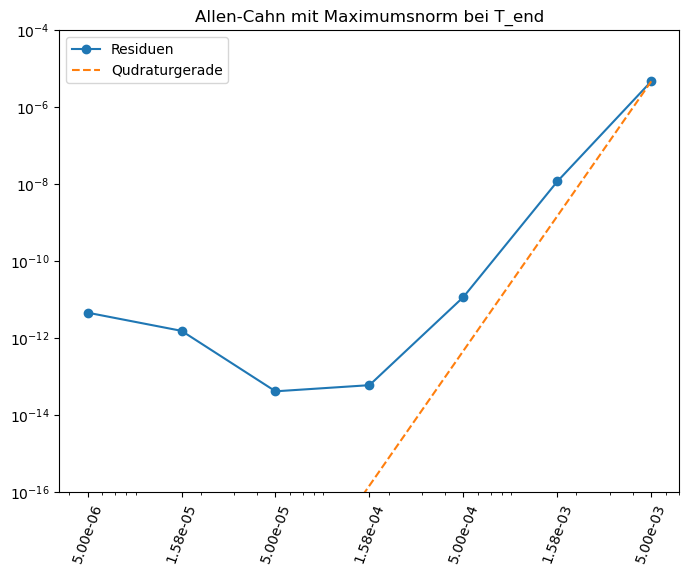

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
conv_line = np.power(dts_allen, 7) * norms_allen[0]/np.power(dts_allen[0], 7)
ax.plot(dts_allen, norms_allen, marker = "o", label="Residuen")
ax.plot(dts_allen, conv_line, linestyle="dashed", label="Qudraturgerade")
ax.set_xscale("log", base = 10)
ax.set_xticks(dts_allen, labels=["{:.2e}".format(dt) for dt in dts_allen], rotation=70)
ax.set_yscale("log", base = 10)
ax.set_ylim(1E-16, 1E-4)
plt.legend()
ax.set_title("Allen-Cahn mit Maximumsnorm bei T_end")
plt.savefig("allencahn_maximumsnorm.png")

In [4]:
def nonlinear_sdc_fisher(dt = 0.05, t_end = 0.1, num_nodes = 5):
    # instantiate problem
    prob = generalized_fisher()

    coll = CollBase(num_nodes=num_nodes, tleft=0, tright=1, node_type='LEGENDRE', quad_type='RADAU-RIGHT')

    generator = QDELTA_GENERATORS['MIN-SR-S'](
        # for algebraic types (LU, ...)
        Q=coll.generator.Q,
        # for MN in tables, MIN-SR-S ...
        nNodes=coll.num_nodes,
        nodeType=coll.node_type,
        quadType=coll.quad_type,
        # for time-stepping types, MIN-SR-NS
        nodes=coll.nodes,
        tLeft=coll.tleft,
    )
    QDmat = generator.genCoeffs(k=None)
    num_nodes = coll.num_nodes 


    # shrink collocation matrix: first line and column deals with initial value, not needed here
    Q = coll.Qmat[1:, 1:]

    u0 = prob.u_exact(t=0).flatten()
    # fill in u0-vector as right-hand side for the collocation problem
    u0_coll = np.kron(np.ones(num_nodes), u0)

    nvars = prob.nvars 

    uk = u0_coll
    fk = np.zeros(nvars * num_nodes, dtype='float64')

    ksum = 0
    k_max = 1_000
    abs_tol = 1E-7
    rel_tol= 1E-7
    newton_res_buffer = np.array([])
    timepoints = np.arange(start = 0, stop = t_end+dt, step = dt)
    u_buffer = np.empty((len(timepoints), nvars)) 
    u_buffer[0] = u0
    lam1 = prob.lambda0/2.0 * ((prob.nu/2.0 + 1) ** 0.5 + (prob.nu/2.0 + 1) **(-0.5))
    sig1 = lam1 - np.sqrt(lam1**2-prob.lambda0**2)

    count = counter()
    for index, timepoint in enumerate(timepoints[:-1]): 
        k = 0
        while k < k_max:
            # eval rhs
            for m in range(num_nodes):
                fk[m * nvars: (m + 1) * nvars] = prob.eval_f(uk[m * nvars: (m + 1) * nvars],
                                                             t=timepoint + dt * coll.nodes[m]).flatten()
    
            resnorm = np.linalg.norm(u0_coll - (uk - dt * sp.kron(Q, sp.eye(nvars)).dot(fk)), np.inf)
            #print('SDC:', k, ksum, resnorm)
            if resnorm < abs_tol and resnorm/np.linalg.norm(u0)< rel_tol:
                break
    
            g = np.zeros(nvars * num_nodes, dtype='float64')
            vn = uk
            fn = np.zeros(nvars * num_nodes, dtype='float64')
            n = 0
            n_max = 1_000 #fixed_newton_iteration
            res_newton = 0
            while n < n_max:
                for m in range(num_nodes):
                    fn[m * nvars: (m + 1) * nvars] = prob.eval_f(vn[m * nvars: (m + 1) * nvars],
                                                                 t=timepoint + dt * coll.nodes[m]).flatten()
                g[:] = u0_coll + dt * sp.kron(Q-QDmat, sp.eye(nvars)).dot(fk) - (vn - dt * sp.kron(QDmat, sp.eye(nvars)).dot(fn))
    
                # if g is close to 0, then we are done
                res_newton = np.linalg.norm(g, np.inf)
                rel_err = np.linalg.norm(vn-uk, np.inf) 
                #print('  Newton:', n, res_newton)
                n += 1
                if res_newton < abs_tol and rel_err < rel_tol * np.linalg.norm(vn, np.inf): 
                    break
    
                # assemble dg
                laplace_dif = sp.kron(sp.eye(num_nodes), prob.A[1:-1, 1:-1])
                growth_dif = np.power(prob.lambda0, 2)* sp.diags(1.0-(prob.nu + 1) *np.power(vn, prob.nu), offsets=0)
                dg = -sp.eye(nvars * num_nodes) + dt * sp.kron(QDmat, sp.eye(nvars)).dot(laplace_dif + growth_dif)
    
                # Newton
                #vn -= sp.linalg.spsolve(dg, g)
                vn -= sp.linalg.gmres(dg, g, x0=np.zeros_like(vn), maxiter=1000, atol=1E-14, callback=count, callback_type='legacy')[0]
             
            uk = vn.copy()
            newton_res_buffer = np.append(newton_res_buffer, res_newton)
            k += 1

        temp = uk[-nvars:].copy()
        u_buffer[index+1, :] = temp
        u0_coll = np.kron(np.ones(num_nodes), temp).flatten()

    r1 = u_buffer
    r2 = timepoints
    return r1, r2

In [5]:
gen_fisher = generalized_fisher()

In [11]:
func_u_exact = np.vectorize(gen_fisher.u_exact, otypes=[np.ndarray])

In [6]:
u, t = nonlinear_sdc_fisher(dt = 0.005)
u_exact = gen_fisher.u_exact(t[-1])
np.max(np.abs(u[-1] - u_exact))

np.float64(6.1616864210911615e-06)

In [20]:
dts = 5/np.power(10, np.arange(2, 5))
norms = np.empty(len(dts))

for index, dt in enumerate(dts):
    print("loop index: " + str(dt))
    u, t = nonlinear_sdc_fisher(dt = dt)
    norms[index] = np.linalg.norm(u[-1] - gen_fisher.u_exact(t[-1]), np.inf)

loop index: 0.05
(5, 5)
loop index: 0.005
(5, 5)
loop index: 0.0005
(5, 5)


In [21]:
norms

array([9.08441167e-06, 6.16168641e-06, 6.16168641e-06])

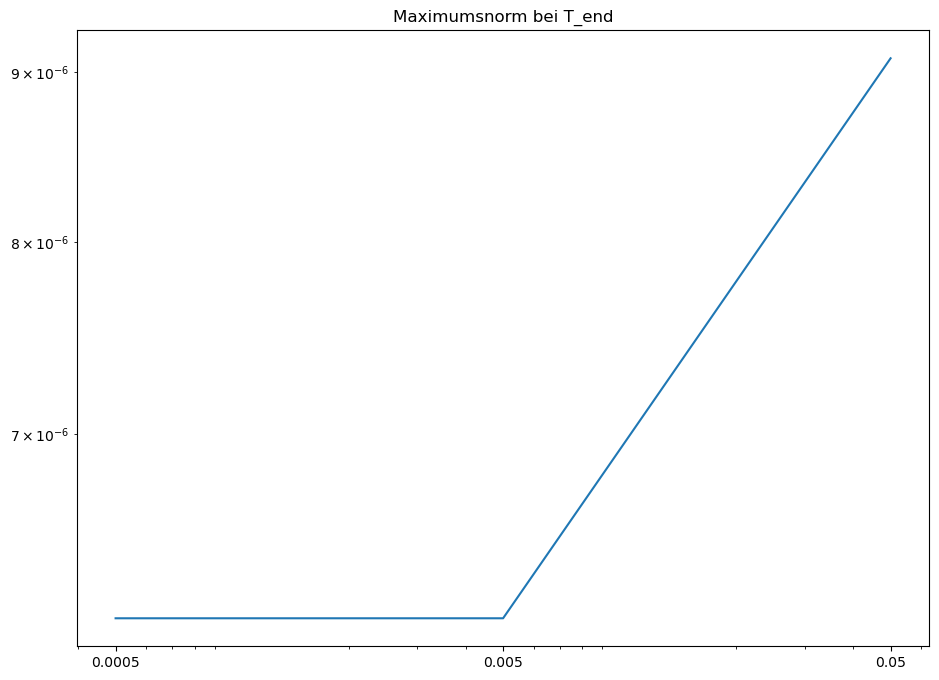

In [22]:
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(dts, norms)
ax.set_xscale("log", base = 10)
ax.set_xticks(dts, labels=dts)
ax.set_yscale("log", base = 10)
ax.set_title("Maximumsnorm bei T_end")
plt.savefig("maximumsnorm.png")